[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/azad-academy/denoising-diffusion-model/blob/main/diffusion_model_demo.ipynb)

# Diffusion Models Tutorial

#### Author : J. Rafid Siddiqui (jrs@azaditech.com)


## Loading Data

shape of s curve: (10000, 2)


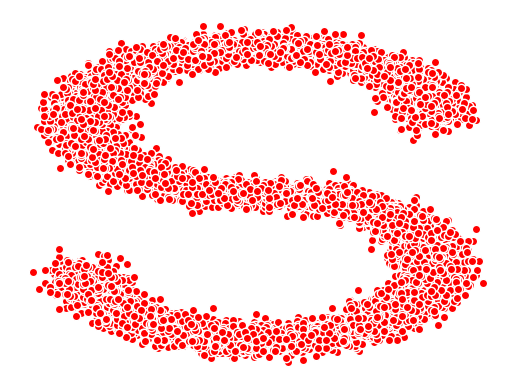

In [1]:
""" 1.加载数据集 """
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve # a 's' curve dataset in sklearn
import torch

s_curve, _= make_s_curve(10**4, noise=0.1) # 10k points
s_curve = s_curve[:, [0, 2]]/10.0 # only take the first and third dimensions

print("shape of s curve:", np.shape(s_curve))

data = s_curve.T # get (2,  10000)
#dataset = torch.Tensor(data.T).float()

fig, axes = plt.subplots()
axes.scatter(*data, color = 'red', edgecolor='white'); #The *data syntax is unpacking the transposed data array into two separate arrays for x and y coordinates.
axes.axis('off')

dataset = torch.Tensor(s_curve).float() # 本次数据集较为简单，直接设置成张量，当作数据集用就行

## Diffusion Models

![diffusion-image](https://github.com/azad-academy/denoising-diffusion-model/blob/main/images/diffusion.png?raw=1)

### Forward Diffusion

$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_{t} ; \sqrt{1-\beta_{t}}\mathbf{x}_{t-1},\beta_{t}\mathbf{I})
$$

Substituting $\alpha_{t}=1-\beta_{t}$ and $\bar{\alpha}_{t} = \prod_{s=1}^{t} \alpha_{s}$:

$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{0}) = \mathcal{N}(\mathbf{x}_{t} ; \sqrt{\bar{\alpha}_{t}}\mathbf{x}_{t-1},(1-\bar{\alpha}_{t})\mathbf{I})
$$

Given the initial state, this makes it possible to draw sample at any desrired timestep without going through intermediate steps. Forward diffusion can also be written in terms of $x_0$ and the random noise $\epsilon \sim \mathcal{N}(0,1)$ [1]. This would be useful when performing denoising step later in the reverse diffusion.

$$
x_t(x_0,\epsilon) = \sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0} + \sqrt{1-\bar{\alpha_{t}}}\epsilon          
$$

In [2]:
""" 2.确定超参数的值 """
num_steps = 100 # 设置走的步数，可以通过 β，分布的均值以及标准差共同决定
# betas = torch.tensor([1.7e-5] * num_steps)
# betas = make_beta_schedule(schedule='sigmoid', n_timesteps=num_steps, start=1e-5, end=0.5e-2)

# 制定每一步的β值，其逐步递增，类似学习率
betas = torch.linspace(-6, 6, num_steps)
betas = torch.sigmoid(betas) * (0.5e-2 - 1e-5) + 1e-5
# betas大概是从0.00001~0.005. sigmoid(-6) ≈ 0，sigmoid(6) ≈ 1


alphas = 1 - betas # α_t
alphas_prod = torch.cumprod(alphas, 0) # \bar{α_t}, 连乘得到. 0表示使用第0维的数据
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0) # previous, \bar{α_(t-1)}。第一项取 1，剩下的取 alphas_prod 第一项到倒数第二像，最后的 0 代表在dimension 0操作
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

assert alphas.shape==alphas_prod.shape==alphas_prod_p.shape== \
alphas_bar_sqrt.shape==one_minus_alphas_bar_log.shape == \
one_minus_alphas_bar_sqrt.shape
print("all the same shape:", betas.shape)

all the same shape: torch.Size([100])


$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{0}) = \mathcal{N}(\mathbf{x}_{t} ; \sqrt{\bar{\alpha}_{t}}\mathbf{x}_{t-1},(1-\bar{\alpha}_{t})\mathbf{I})
$$

alphas_t = alphas_bar_sqrt[t], it's $\sqrt{\bar{\alpha_t}}$, the **mean**.

alphas_l_m_t = one_minus_alphas_bar_sqrt[t], it's $\sqrt{1-\bar{\alpha_{t}}}$, the **variance**.

Return the following one:
$$
x_t(x_0,\epsilon) = \sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0} + \sqrt{1-\bar{\alpha_{t}}}\epsilon          
$$

In [3]:
""" 3.确定扩散过程任意时刻的采样值 """
def q_x(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0) # noise 是从正态分布生成的随机噪声
    # alphas_t = extract(alphas_bar_sqrt, t, x_0)
    # alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    alphas_t = alphas_bar_sqrt[t] # torch.size([1])
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
    return (alphas_t * x_0 + alphas_1_m_t * noise)

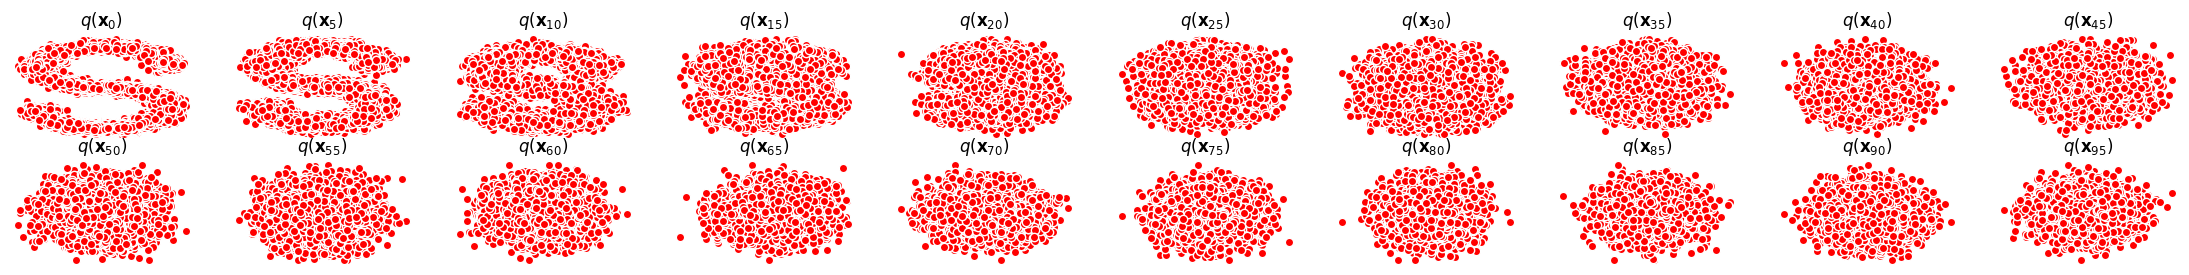

In [4]:
""" 4.showing how it looks like when add noise for 100 steps """
num_shows = 20
fig, axs = plt.subplots(2, 10, figsize=(28, 3))
plt.rc('text', color='blue')

# dataset: (10000, 2)
# 生成100步以内，每隔5步加噪声后的图像, num_steps = 100
for i in range(num_shows):
    j = i // 10 # 十位数
    k = i % 10 # 个位数
    q_i = q_x(dataset, torch.tensor([i * num_steps // num_shows])) # 生成t时刻的采样值

    axs[j, k].scatter(q_i[:,0], q_i[:,1], color = 'red', edgecolor = 'white')
    axs[j, k].set_axis_off()
    axs[j, k].set_title('$q(\mathbf{x}_{'+str(i * num_steps // num_shows)+'})$')

    # q_i = q_x(dataset, torch.tensor([i * 10]))
    # axs[i].scatter(q_i[:, 0], q_i[:, 1],color='white',edgecolor='gray', s=5);
    # axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

## Reverse Diffusion/Reconstruction

Unlike the forward diffusion, the reverse diffusion process requires training of a neural network model. We setup the necessary loss functions and training parameters and then perform the training.

## Training

### Training Loss

The original loss was proposed in Sohl-Dickstein et al. [1] as following:

\begin{align}
K = -\mathbb{E}_{q}[ &D_{KL}(q(\mathbf{x}_{t-1}\mid\mathbf{x}_{t},\mathbf{x}_{0}) \Vert p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t}))  \\
&+ H_{q}(\mathbf{X}_{T}\vert\mathbf{X}_{0}) - H_{q}(\mathbf{X}_{1}\vert\mathbf{X}_{0}) - H_{p}(\mathbf{X}_{T})]
\end{align}


In order to improve the results, the authors in Ho et al. [2] proposed multiple improvements. Following Parameterization of mean is proposed:

$$
\mathbf{\mu}_{\theta}(\mathbf{x}_{t}, t) = \frac{1}{\sqrt{\alpha_{t}}} \left( (\mathbf{x}_{t} - \frac{\beta_{t}}{\sqrt{1 - \bar{\alpha}}_{t}} \mathbf{\epsilon}_{\theta} (\mathbf{x}_{t}, t) \right)
$$

further, variance is taken as constant and the step for reverse diffusion then becomes:

$$
\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_{t}}} \left( \mathbf{x}_{t} - \frac{1-\alpha_{t}}{\sqrt{1-\bar{\alpha_{t}}}} \mathbf{\epsilon}_{\theta}(\mathbf{x}_{t}, t) \right) + \sigma_{t}\mathbf{z}
$$



After further improvements and simplifications the loss function becomes:

$$
\mathcal{L}_{\text{simple}}=\mathbb{E}_{t, \mathbf{x}_{0},\mathbf{\epsilon}}\left[ \Vert \epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0} + \sqrt{1 - \bar{\alpha}_{t}}\mathbf{\epsilon}, t) \Vert^{2} \right].
$$

In [16]:
""" 5.编写拟合扩散过程的高斯分布模型 """
import torch
import torch.nn as nn

class MLPDiffusion(nn.Module):
  def __init__(self, n_steps, num_units = 128): # n_step 设定的迭代步数T, num_units 隐藏层的units (neurons)个数
    super(MLPDiffusion, self).__init__()

    # 线性层
    self.linears = nn.ModuleList( # MLP
        [
            nn.Linear(2, num_units), # maps 2 input features to num_units features.
            nn.ReLU(),
            nn.Linear(num_units, num_units),
            nn.ReLU(),
            nn.Linear(num_units, num_units),
            nn.ReLU(),
            nn.Linear(num_units, 2), # still output 2 features
        ]
    )

    # 每个embedding都是全新的可迭代的参数
    # Each embedding layer maps the number of steps (n_steps) to num_units features.
    self.step_embeddings = nn.ModuleList(
        [
            nn.Embedding(n_steps, num_units),
            nn.Embedding(n_steps, num_units),
            nn.Embedding(n_steps, num_units),
        ]
    )

  def forward(self, x, t): # x_0: the initial input data, t: The time step indices for embeddings.
    for idx, embedding_layer in enumerate(self.step_embeddings):
      t_embedding = embedding_layer(t)
      x = self.linears[2 * idx](x)
      x += t_embedding # embeddings是通过 加法 来加入的
      x = self.linears[2 * idx + 1](x)

    x = self.linears[-1](x)

    return x

$$
\mathcal{L}_{\text{simple}}=\mathbb{E}_{t, \mathbf{x}_{0},\mathbf{\epsilon}}\left[ \Vert \epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0} + \sqrt{1 - \bar{\alpha}_{t}}\mathbf{\epsilon}, t) \Vert^{2} \right].
$$

In [14]:
""" 6.编写训练时的误差函数 """
def diffusion_loss_fn(model, x_0, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
  # 对任意时刻的t进行采样计算loss

  batch_size = x_0.shape[0]

  # 对一个batchsize样本生成随机时刻的t，目的是想覆盖到更多不同的t
  t = torch.randint(0, n_steps, size = (batch_size//2,))
  t = torch.cat([t, n_steps - 1 - t], dim = 0) # t.shape: [batch_size]
  t = t.unsqueeze(-1) # t.shape: [bacth_size, 1]

  # x_0的系数
  a = alphas_bar_sqrt[t]

  # 噪声eps的系数
  aml = one_minus_alphas_bar_sqrt[t]

  # 生成随机噪声eps
  e = torch.randn_like(x_0)

  # 构造模型的一个输入，L_simple小括号里面那一块
  x = x_0 * a + e * aml

  # 送入模型，得到 t 时刻的随机噪声预测值，即 ε_θ 的输出
  output = model(x, t.squeeze(-1)) # t.squeeze .shape: [bacth_size]

  # 与真实噪声一起计算误差，求平均值 （Looks like MSE..）
  return (e - output).square().mean()

$$
\mathbf{\mu}_{\theta}(\mathbf{x}_{t}, t) = \frac{1}{\sqrt{\alpha_{t}}} \left( (\mathbf{x}_{t} - \frac{\beta_{t}}{\sqrt{1 - \bar{\alpha}}_{t}} \mathbf{\epsilon}_{\theta} (\mathbf{x}_{t}, t) \right)
$$

In [8]:
""" 7.编写逆扩散采样函数（inference过程） """
def p_sample_loop(model, shape, n_steps, betas, one_minus_alphas_bar_sqrt):
  # 从x[T]恢复x[T-1], x[T-2],... ,x[0]
  cur_x = torch.randn(shape)
  x_seq = [cur_x]
  for i in reversed(range(n_steps)):
    cur_x = p_sample(model, cur_x, i, betas, one_minus_alphas_bar_sqrt)
    x_seq.append(cur_x)
  return x_seq

def p_sample(model, x, t, batas, one_minus_alphas_bar_sqrt):
  # 从x[T]采样t时刻的重构值
  t = torch.tensor([t])
  coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
  eps_theta = model(x, t)
  mean = (1 / (1 - betas[t]).sqrt()) * (x - (coeff * eps_theta)) # 均值μ

  z = torch.randn_like(x) # 正态分布随机量
  sigma_t = betas[t].sqrt() # 方差σ

  sample = mean + sigma_t * z

  return (sample)


In [18]:
""" 8.开始训练模型，并打印loss及中间的重构效果 """
seed = 1234

# 参数平滑器， 在这个数据集训练会变慢，暂时不用
# class EMA():
#   def __init__(self, mu = 0.01):
#     self.mu = mu
#     self.shadow = {}

#   def register(self, name, val):
#     self.shadow[name = val.clone]()

#   def __call__(self, name, x):
#     assert name in self.shadow
#     new_average = self.mu * x + (1.0 - self.mu) * self.shadow[name]
#     self.shadow[name] = new_average.clone()
#     return new_average

print('Training model...')

batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
num_epoch = 4000 # 迭代次数
plt.rc('text', color = 'blue')

model = MLPDiffusion(num_steps) # 实例化模型，输出维度是2，输入是x和step
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # 学习率0.001

for t in range(num_epoch):
  for idx, batch_x in enumerate(dataloader):
    loss = diffusion_loss_fn(model, batch_x, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
    optimizer.zero_grad()
    loss.backward() # 算出梯度
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.) # clip截取，保持稳定性
    optimizer.step()

    # for name, param in model.named_parameters():
    #   if param.requires_grad:
    #     param.data = ema(name, param.data)

  # Print loss
  if (t % 100 == 0): # 每100个周期采样一次
    print(loss)
    # 共4000个周期，每个周期100步）
    x_seq = p_sample_loop(model, dataset.shape, num_steps, betas, one_minus_alphas_bar_sqrt) # 共100个元素

    fig, axs = plt.subplots(1, 10, figsize=(28, 3))
    for i in range(1, 11):
      cur_x = x_seq[i * 10].detach()
      axs[i - 1].scatter(cur_x[:, 0], cur_x[:, 1], color = 'red', edgecolor = 'white');
      axs[i - 1].set_axis_off();
      axs[i - 1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

Output hidden; open in https://colab.research.google.com to view.

## Animation

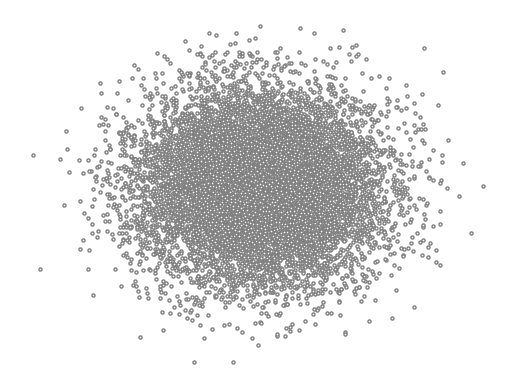

In [19]:
# Generating the forward image sequence

import io
from PIL import Image

imgs = []
#fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(100):
    plt.clf()
    q_i = q_x(dataset, torch.tensor([i]))
    plt.scatter(q_i[:, 0], q_i[:, 1],color='white',edgecolor='gray', s=5);
    plt.axis('off');

    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    imgs.append(img)


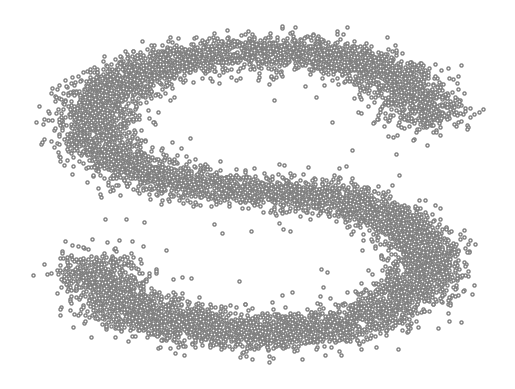

In [20]:
# Generating the reverse diffusion sequence

reverse = []
for i in range(100):
    plt.clf()
    cur_x = x_seq[i].detach()
    plt.scatter(cur_x[:, 0], cur_x[:, 1],color='white',edgecolor='gray', s=5);
    plt.axis('off')

    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    reverse.append(img)

In [21]:
imgs = imgs + reverse

In [22]:
imgs[0].save("diffusion.gif", format='GIF', append_images=imgs,save_all=True, duration=100, loop=0)

In [23]:
!ls

diffusion.gif  sample_data


# References

[1] Ho, J., Jain, A., & Abbeel, P. (2020). Denoising diffusion probabilistic models. arXiv preprint arXiv:2006.11239.

[2] Sohl-Dickstein, J., Weiss, E. A., Maheswaranathan, N., & Ganguli, S. (2015). Deep unsupervised learning using nonequilibrium thermodynamics. arXiv preprint arXiv:1503.03585.